In [1]:
%matplotlib notebook
import datetime as dt  # Python standard library datetime  module
import numpy as np
import netCDF4  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

import s2_py as s2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping

import os
import pickle
import wget
import subprocess


import matplotlib.animation as animation

import google.cloud.bigquery
import pandas_gbq
import pandas as pd
import shapefile as shp
import descartes
from shapely.geometry import Polygon, mapping, Point
from sklearn.metrics.pairwise import euclidean_distances

import itertools

In [2]:
# Courtesy Yulia
ca_s2_df = gpd.read_file("/home/scott/w210_Wildfire/DataPrep/Data/Processed/CA_S2Cells/CA_S2Cells.shp")

In [3]:
ca_s2_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_are,FZ_grp,S2_Cells_I,geometry
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4,POLYGON ((-116.9852421934208 36.92851788893871...
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac,POLYGON ((-117.1735315927328 36.88229296981148...
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4,POLYGON ((-117.1735315927328 37.04169221702246...
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44,POLYGON ((-118.2994349957241 37.38986432048104...
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c,POLYGON ((-118.2994349957241 37.23225420438236...


In [4]:
len(ca_s2_df)

10643

In [5]:
fapar2016 = pd.read_csv('/home/scott/sat_aggs/fapar2016.csv')

/home/scott/anaconda3/envs/sat/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
fapar2016.head()

,mergeKey,latIdx_min,latIdx_max,latIdx_myMean,latIdx_myMedian,latIdx_myStd,latIdx_size,latIdx_count,latIdx_nunique,lat_min,...,faparVal_count,faparVal_nunique,faparMask_min,faparMask_max,faparMask_myMean,faparMask_myMedian,faparMask_myStd,faparMask_size,faparMask_count,faparMask_nunique
0,54c934,0,32,11.703905,11.0,7.712635,2023,2023,33,41.958333,...,2023,540,False,True,0.575877,True,0.494209,2023,2023,2
1,54c9354,19,32,25.145631,25.0,3.028691,206,206,14,41.958333,...,206,115,False,True,0.184466,False,0.387864,206,206,2
2,54c935c,14,27,20.281553,20.0,3.038323,206,206,14,41.973214,...,206,106,False,True,0.242718,False,0.428726,206,206,2
3,54c9364,9,22,15.409756,15.0,3.053651,205,205,14,41.988095,...,205,85,False,True,0.375610,False,0.484280,205,205,2
4,54c9414,8,22,15.014563,15.0,3.063214,206,206,15,41.988095,...,206,24,False,True,0.820388,True,0.383864,206,206,2


In [7]:
fapar2016.columns

Index(['mergeKey', 'latIdx_min', 'latIdx_max', 'latIdx_myMean',
       'latIdx_myMedian', 'latIdx_myStd', 'latIdx_size', 'latIdx_count',
       'latIdx_nunique', 'lat_min', 'lat_max', 'lat_myMean', 'lat_myMedian',
       'lat_myStd', 'lat_size', 'lat_count', 'lat_nunique', 'lonIdx_min',
       'lonIdx_max', 'lonIdx_myMean', 'lonIdx_myMedian', 'lonIdx_myStd',
       'lonIdx_size', 'lonIdx_count', 'lonIdx_nunique', 'lon_min', 'lon_max',
       'lon_myMean', 'lon_myMedian', 'lon_myStd', 'lon_size', 'lon_count',
       'lon_nunique', 'faparVal_min', 'faparVal_max', 'faparVal_myMean',
       'faparVal_myMedian', 'faparVal_myStd', 'faparVal_size',
       'faparVal_count', 'faparVal_nunique', 'faparMask_min', 'faparMask_max',
       'faparMask_myMean', 'faparMask_myMedian', 'faparMask_myStd',
       'faparMask_size', 'faparMask_count', 'faparMask_nunique'],
      dtype='object')

# I left off the date stamps!  But I can go back and get them from the filenames.

In [11]:
len(fapar2016)

383148

In [12]:
len(fapar2016) / len(ca_s2_df)

36.0

In [13]:
data_dir = '/home/scott/sat_aggs/'
csvfiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        csvfiles[filename] = (os.path.join(dirpath, filename))

In [14]:
csvfiles.keys()

dict_keys(['20161031_agg.csv', '20160710_agg.csv', '20160920_agg.csv', '20170630_agg.csv', '20170120_agg.csv', '20161231_agg.csv', '20160810_agg.csv', '20170510_agg.csv', '20170320_agg.csv', '20160520_agg.csv', '20160229_agg.csv', '20170228_agg.csv', '20170831_agg.csv', '20170520_agg.csv', '20170110_agg.csv', '20190110_agg.csv', '20160910_agg.csv', '20171020_agg.csv', '20170930_agg.csv', '20170731_agg.csv', '20170610_agg.csv', '20160420_agg.csv', '20160510_agg.csv', 'fapar2016.csv', '20171010_agg.csv', '20170910_agg.csv', '20160620_agg.csv', '20160110_agg.csv', '20170720_agg.csv', '20160930_agg.csv', '20160731_agg.csv', '20170310_agg.csv', '20170220_agg.csv', '20170410_agg.csv', '20160820_agg.csv', '20160331_agg.csv', '20160410_agg.csv', '20160210_agg.csv', '20160120_agg.csv', '20160831_agg.csv', '20160320_agg.csv', '20170420_agg.csv', '20160430_agg.csv', '20170430_agg.csv', '20161210_agg.csv', '20161120_agg.csv', '20160310_agg.csv', '20171031_agg.csv', '20160720_agg.csv', '20160131_ag

In [ ]:
for file in csvfiles.keys():
    df = pd.read_csv(file)

In [55]:
file = list(csvfiles.keys())[0]
file


'20161031_agg.csv'

In [56]:
df = pd.read_csv(csvfiles[file])
df.head()

,mergeKey,latIdx_min,latIdx_max,latIdx_myMean,latIdx_myMedian,latIdx_myStd,latIdx_size,latIdx_count,latIdx_nunique,lat_min,...,faparVal_count,faparVal_nunique,faparMask_min,faparMask_max,faparMask_myMean,faparMask_myMedian,faparMask_myStd,faparMask_size,faparMask_count,faparMask_nunique
0,54c934,0,32,11.703905,11.0,7.712635,2023,2023,33,41.958333,...,2023,263,False,True,0.001483,False,0.038480,2023,2023,2
1,54c9354,19,32,25.145631,25.0,3.028691,206,206,14,41.958333,...,206,129,False,True,0.004854,False,0.069504,206,206,2
2,54c935c,14,27,20.281553,20.0,3.038323,206,206,14,41.973214,...,206,115,False,False,0.000000,False,0.000000,206,206,1
3,54c9364,9,22,15.409756,15.0,3.053651,205,205,14,41.988095,...,205,112,False,False,0.000000,False,0.000000,205,205,1
4,54c9414,8,22,15.014563,15.0,3.063214,206,206,15,41.988095,...,206,49,False,True,0.009709,False,0.098053,206,206,2


In [57]:
dateStart = file.find(str(year))
date = file[dateStart:dateStart+8]
date


'20161031'

In [63]:
#df['date'] = date[0:4] + '-' + date[5:7] + '-' + date[7:]
dateFormatted = date[0:4] + '-' + date[4:6] + '-' + date[6:]
dateFormatted

'2016-10-31'

In [64]:
df['date'] = dateFormatted
df.head()

,mergeKey,latIdx_min,latIdx_max,latIdx_myMean,latIdx_myMedian,latIdx_myStd,latIdx_size,latIdx_count,latIdx_nunique,lat_min,...,faparVal_nunique,faparMask_min,faparMask_max,faparMask_myMean,faparMask_myMedian,faparMask_myStd,faparMask_size,faparMask_count,faparMask_nunique,date
0,54c934,0,32,11.703905,11.0,7.712635,2023,2023,33,41.958333,...,263,False,True,0.001483,False,0.038480,2023,2023,2,2016-10-31
1,54c9354,19,32,25.145631,25.0,3.028691,206,206,14,41.958333,...,129,False,True,0.004854,False,0.069504,206,206,2,2016-10-31
2,54c935c,14,27,20.281553,20.0,3.038323,206,206,14,41.973214,...,115,False,False,0.000000,False,0.000000,206,206,1,2016-10-31
3,54c9364,9,22,15.409756,15.0,3.053651,205,205,14,41.988095,...,112,False,False,0.000000,False,0.000000,205,205,1,2016-10-31
4,54c9414,8,22,15.014563,15.0,3.063214,206,206,15,41.988095,...,49,False,True,0.009709,False,0.098053,206,206,2,2016-10-31


In [65]:
df2 = df.drop(['latIdx_min',
               'latIdx_max',
               'latIdx_myMean',
               'latIdx_myMedian',
               'latIdx_myStd',
               'latIdx_size',
               'latIdx_count',
               'latIdx_nunique',
               'lonIdx_min',
               'lonIdx_max',
               'lonIdx_myMean',
               'lonIdx_myMedian',
               'lonIdx_myStd',
               'lonIdx_size',
               'lonIdx_count',
               'lonIdx_nunique'],
              axis = 1)

In [66]:
df2.head()

,mergeKey,lat_min,lat_max,lat_myMean,lat_myMedian,lat_myStd,lat_size,lat_count,lat_nunique,lon_min,...,faparVal_nunique,faparMask_min,faparMask_max,faparMask_myMean,faparMask_myMedian,faparMask_myStd,faparMask_size,faparMask_count,faparMask_nunique,date
0,54c934,41.958333,42.053571,42.018738,42.020833,0.022954,2023,2023,33,-121.610119,...,263,False,True,0.001483,False,0.038480,2023,2023,2,2016-10-31
1,54c9354,41.958333,41.997024,41.978733,41.979167,0.009014,206,206,14,-121.526786,...,129,False,True,0.004854,False,0.069504,206,206,2,2016-10-31
2,54c935c,41.973214,42.011905,41.993210,41.994048,0.009043,206,206,14,-121.479167,...,115,False,False,0.000000,False,0.000000,206,206,1,2016-10-31
3,54c9364,41.988095,42.026786,42.007709,42.008929,0.009088,205,205,14,-121.431548,...,112,False,False,0.000000,False,0.000000,205,205,1,2016-10-31
4,54c9414,41.988095,42.029762,42.008885,42.008929,0.009117,206,206,15,-121.172619,...,49,False,True,0.009709,False,0.098053,206,206,2,2016-10-31


In [67]:
df2.columns

Index(['mergeKey', 'lat_min', 'lat_max', 'lat_myMean', 'lat_myMedian',
       'lat_myStd', 'lat_size', 'lat_count', 'lat_nunique', 'lon_min',
       'lon_max', 'lon_myMean', 'lon_myMedian', 'lon_myStd', 'lon_size',
       'lon_count', 'lon_nunique', 'faparVal_min', 'faparVal_max',
       'faparVal_myMean', 'faparVal_myMedian', 'faparVal_myStd',
       'faparVal_size', 'faparVal_count', 'faparVal_nunique', 'faparMask_min',
       'faparMask_max', 'faparMask_myMean', 'faparMask_myMedian',
       'faparMask_myStd', 'faparMask_size', 'faparMask_count',
       'faparMask_nunique', 'date'],
      dtype='object')

In [68]:
len(df2)

10643

In [69]:
file

'20161031_agg.csv'

In [71]:
date

'20161031'

In [72]:
'/home/scott/sat_aggs/' + file[0:-4] + '_date' + file[-4:]

'/home/scott/sat_aggs/20161031_agg_date.csv'

In [73]:
df2.to_csv('/home/scott/sat_aggs/' + file[0:-4] + '_date' + file[-4:])

In [39]:
ca_s2_df['mergeKey'] = ca_s2_df['S2_Cells_I']
df3 = ca_s2_df.merge(df2, on = 'mergeKey')
len(df3)

10643

<IPython.core.display.Javascript object>


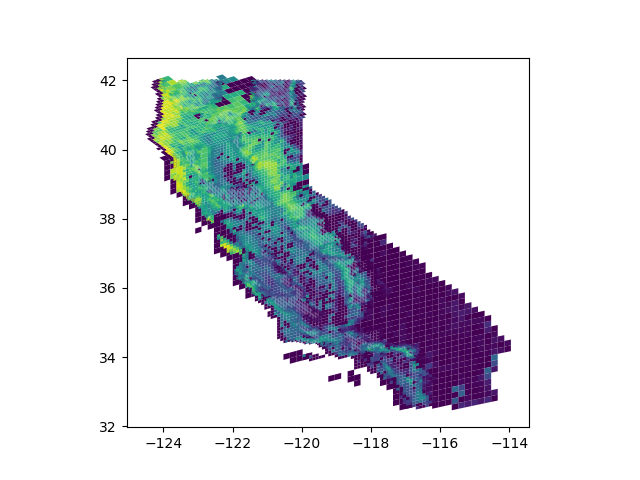

In [40]:
df3.plot(column = 'faparVal_myMean')

<IPython.core.display.Javascript object>


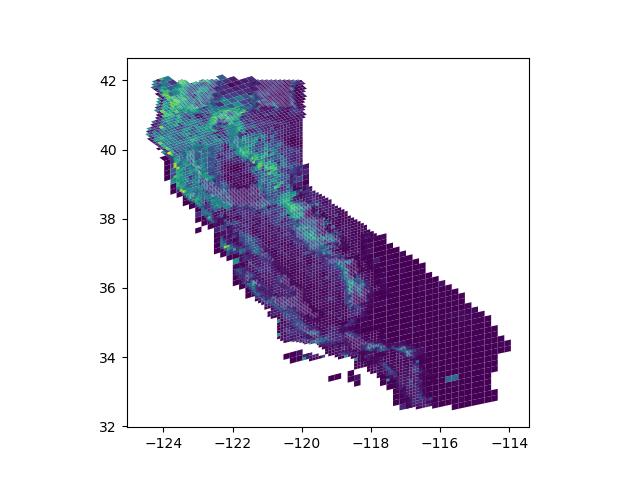

In [42]:
df3.plot(column = 'faparVal_min')

<IPython.core.display.Javascript object>


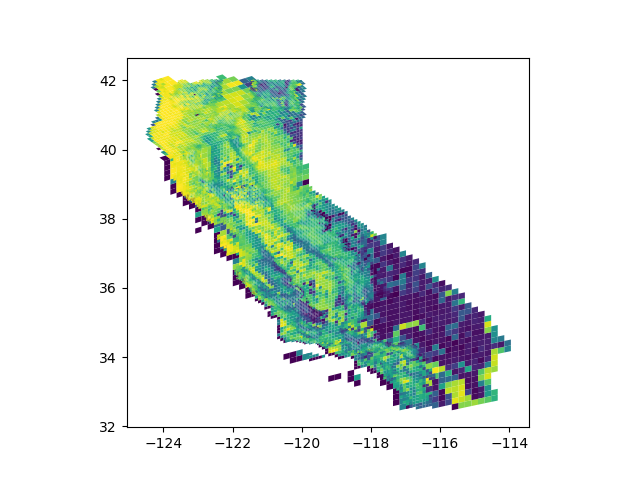

In [43]:
df3.plot(column = 'faparVal_max')

<IPython.core.display.Javascript object>


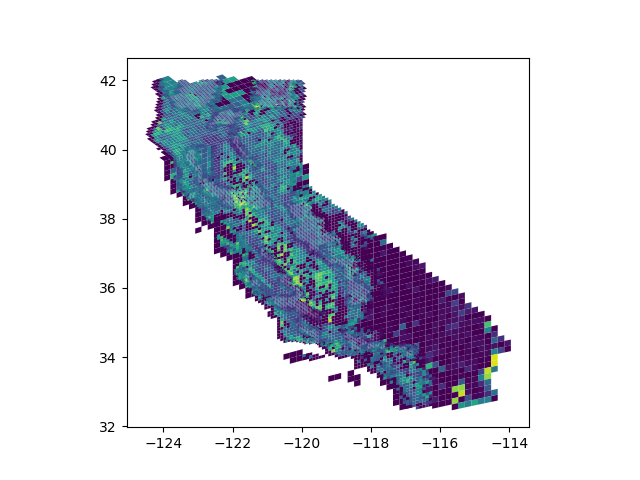

In [44]:
df3.plot(column = 'faparVal_myStd')

<IPython.core.display.Javascript object>


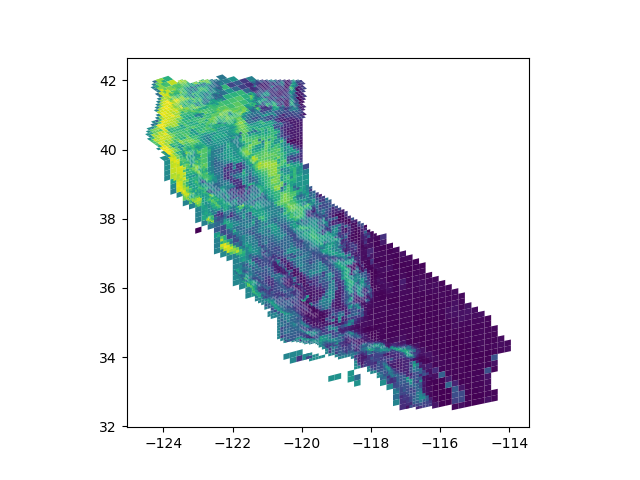

In [47]:
df3.plot(column = 'faparVal_myMedian')

In [76]:
#for year in range(2016, 2019):
year = 2016
dates = []


data_dir = '/home/scott/sat_aggs/'
csvfiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        csvfiles[filename] = (os.path.join(dirpath, filename))

for filename, fullpath in csvfiles.items():
    dateStart = filename.find(str(year))
    if dateStart!= -1: #file includes date of interest
        date = filename[dateStart:dateStart+8]  # 20161031 for example
        dateFormatted = date[0:4] + '-' + date[4:6] + '-' + date[6:]   #2016-10-31 for example
        dates.append(date)
        with open(fullpath, 'rb') as f:
            df = pd.read_csv(f)
        df['date'] = dateFormatted
        df2 = df.drop(['latIdx_min',
               'latIdx_max',
               'latIdx_myMean',
               'latIdx_myMedian',
               'latIdx_myStd',
               'latIdx_size',
               'latIdx_count',
               'latIdx_nunique',
               'lonIdx_min',
               'lonIdx_max',
               'lonIdx_myMean',
               'lonIdx_myMedian',
               'lonIdx_myStd',
               'lonIdx_size',
               'lonIdx_count',
               'lonIdx_nunique'],
              axis = 1)
        df2.to_csv(data_dir + 'dated/' + filename[0:-4] + '_date' + filename[-4:])  #/home/scott/sat_aggs/20161031_agg_date.csv for example


sorted(dates)

['20160110',
 '20160120',
 '20160131',
 '20160210',
 '20160220',
 '20160229',
 '20160310',
 '20160320',
 '20160331',
 '20160410',
 '20160420',
 '20160430',
 '20160510',
 '20160520',
 '20160531',
 '20160610',
 '20160620',
 '20160630',
 '20160710',
 '20160720',
 '20160731',
 '20160810',
 '20160820',
 '20160831',
 '20160910',
 '20160920',
 '20160930',
 '20161010',
 '20161020',
 '20161031',
 '20161110',
 '20161120',
 '20161130',
 '20161210',
 '20161220',
 '20161231']

In [77]:
dates = []
data_dir = '/home/scott/sat_aggs/'
csvfiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        csvfiles[filename] = (os.path.join(dirpath, filename))

for year in range(2017, 2019):
    #year = 2016

    for filename, fullpath in csvfiles.items():
        dateStart = filename.find(str(year))
        if dateStart!= -1: #file includes date of interest
            date = filename[dateStart:dateStart+8]  # 20161031 for example
            dateFormatted = date[0:4] + '-' + date[4:6] + '-' + date[6:]   #2016-10-31 for example
            dates.append(date)
            with open(fullpath, 'rb') as f:
                df = pd.read_csv(f)
            df['date'] = dateFormatted
            df2 = df.drop(['latIdx_min',
                   'latIdx_max',
                   'latIdx_myMean',
                   'latIdx_myMedian',
                   'latIdx_myStd',
                   'latIdx_size',
                   'latIdx_count',
                   'latIdx_nunique',
                   'lonIdx_min',
                   'lonIdx_max',
                   'lonIdx_myMean',
                   'lonIdx_myMedian',
                   'lonIdx_myStd',
                   'lonIdx_size',
                   'lonIdx_count',
                   'lonIdx_nunique'],
                  axis = 1)
            df2.to_csv(data_dir + 'dated/' + filename[0:-4] + '_date' + filename[-4:])  #/home/scott/sat_aggs/20161031_agg_date.csv for example


sorted(dates)

['20170110',
 '20170120',
 '20170131',
 '20170210',
 '20170220',
 '20170228',
 '20170310',
 '20170320',
 '20170331',
 '20170410',
 '20170420',
 '20170430',
 '20170510',
 '20170520',
 '20170531',
 '20170610',
 '20170620',
 '20170630',
 '20170710',
 '20170720',
 '20170731',
 '20170810',
 '20170820',
 '20170831',
 '20170910',
 '20170920',
 '20170930',
 '20171010',
 '20171020',
 '20171031',
 '20171110',
 '20171120',
 '20171130',
 '20171210',
 '20171220',
 '20171231',
 '20180110',
 '20180120',
 '20180131',
 '20180210',
 '20180220',
 '20180228',
 '20180310',
 '20180320',
 '20180331',
 '20180410',
 '20180420',
 '20180430',
 '20180510',
 '20180520',
 '20180531',
 '20180610',
 '20180620',
 '20180630',
 '20180710',
 '20180720',
 '20180731',
 '20180810',
 '20180820',
 '20180831',
 '20180910',
 '20180920',
 '20180930',
 '20181010',
 '20181020',
 '20181031',
 '20181110',
 '20181120',
 '20181130',
 '20181210',
 '20181220',
 '20181231']